# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: November 26, 2021
Pyleecan version:1.3.7
SciDataTool version:1.4.22



# How to define a machine

This tutorial shows the different ways to define electrical machine. To do so, it presents the definition of the **Toyota Prius 2004** interior magnet with distributed winding \[1\].

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Machine.ipynb).

## Type of machines Pyleecan can model
Pyleecan handles the geometrical modelling of main 2D radial flux machines such as:  
- surface or interior permanent magnet machines (SPMSM, IPMSM)  
- synchronous reluctance machines (SynRM)  
- squirrel-cage induction machines and doubly-fed induction machines (SCIM, DFIM)  
- would rotor synchronous machines and salient pole synchronous machines (WSRM)  
- switched reluctance machines (SRM)  

The architecture of Pyleecan also enables to define other kinds of machines (with more than two laminations for instance). More information in our ICEM 2020 pyblication \[2\]

Every machine can be defined by using the **Graphical User Interface** or directly in **Python script**.

## Defining machine with Pyleecan GUI 
The GUI is the easiest way to define machine in Pyleecan. Its purpose is to create or load a machine and save it in JSON format to be loaded in a python script. The interface enables to define step by step in a user-friendly way every characteristics of the machine such as:  
- topology  
- dimensions  
- materials  
- winding  

Each parameter is explained by a tooltip and the machine can be previewed at each stage of the design.


## Start the GUI
The GUI can be started by running the following command in a notebook:
```python
# Start Pyleecan GUI from the Jupyter Notebook
%run -m pyleecan
```
To use it on Anaconda you may need to create the system variable:

QT_QPA_PLATFORM_PLUGIN_PATH : path\to\anaconda3\Lib\site-packages\PySide2\plugins\platforms

The GUI can also be launched in a terminal by calling one of the following commands in a terminal:
```
Path/to/python.exe -m pyleecan
Path/to/python3.exe -m pyleecan
```

## load a machine
Once the machine defined in the GUI it can be loaded with the following commands:

<IPython.core.display.Javascript object>


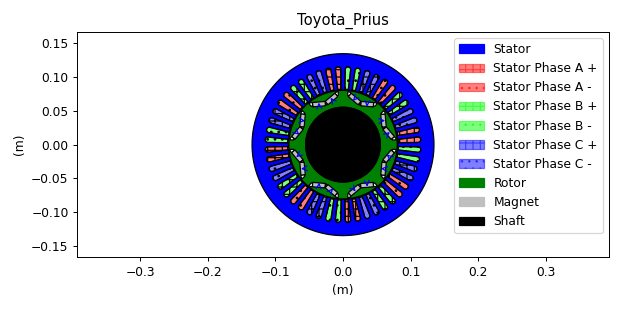

In [2]:
%matplotlib notebook

# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

IPMSM_A = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
IPMSM_A.plot()

## Defining Machine in scripting mode 
Pyleecan also enables to define the machine in scripting mode, using different classes. Each class is defined from a csv file in the folder _pyleecan/Generator/ClasseRef_ and the documentation of every class is available on the dedicated [webpage](https://www.pyleecan.org/pyleecan.Classes.html).
The following image shows the machine classes organization : 

![](https://www.pyleecan.org/_static/machine_classes_UML.png)

Every rotor and stator can be created with the **Lamination** class or one of its daughters.  

![](https://www.pyleecan.org/_static/lamination_classes_UML.png)

The scripting enables to define some complex and exotic machine that can't be defined in the GUI such as this one:

<IPython.core.display.Javascript object>


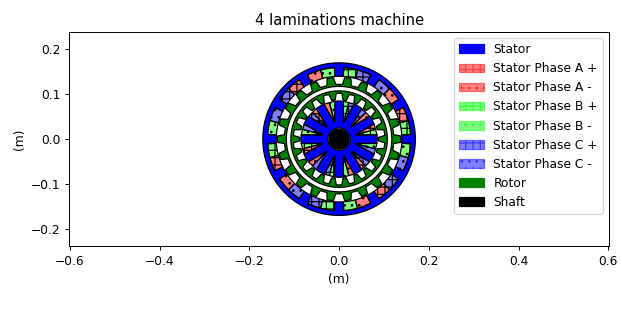

In [3]:
from pyleecan.Classes.MachineUD import MachineUD
from pyleecan.Classes.LamSlotWind import LamSlotWind
from pyleecan.Classes.LamSlot import LamSlot
from pyleecan.Classes.Winding import Winding
from pyleecan.Classes.SlotW10 import SlotW10
from pyleecan.Classes.SlotW22 import SlotW22
from numpy import pi

machine = MachineUD(name="4 laminations machine")

# Main geometry parameter
Rext = 170e-3  # Exterior radius of outter lamination
W1 = 30e-3  # Width of first lamination
A1 = 2.5e-3  # Width of the first airgap
W2 = 20e-3
A2 = 10e-3
W3 = 20e-3
A3 = 2.5e-3
W4 = 60e-3

# Outer stator
lam1 = LamSlotWind(Rext=Rext, Rint=Rext - W1, is_internal=False, is_stator=True)
lam1.slot = SlotW22(
    Zs=12, W0=2 * pi / 12 * 0.75, W2=2 * pi / 12 * 0.75, H0=0, H2=W1 * 0.65
)
lam1.winding = Winding(qs=3, p=2, Nlayer=2)
# External Rotor
lam2 = LamSlot(
    Rext=lam1.Rint - A1, Rint=lam1.Rint - A1 - W2, is_internal=True, is_stator=False
)
lam2.slot = SlotW10(Zs=22, W0=25e-3, W1=25e-3, W2=15e-3, H0=0, H1=0, H2=W2 * 0.75)
# Internal Rotor
lam3 = LamSlot(
    Rext=lam2.Rint - A2,
    Rint=lam2.Rint - A2 - W3,
    is_internal=False,
    is_stator=False,
)
lam3.slot = SlotW10(
    Zs=22, W0=17.5e-3, W1=17.5e-3, W2=12.5e-3, H0=0, H1=0, H2=W3 * 0.75
)
# Inner stator
lam4 = LamSlotWind(
    Rext=lam3.Rint - A3, Rint=lam3.Rint - A3 - W4, is_internal=True, is_stator=True
)
lam4.slot = SlotW10(Zs=12, W0=25e-3, W1=25e-3, W2=1e-3, H0=0, H1=0, H2=W4 * 0.75)
lam4.winding = Winding(qs=3, p=2, Nlayer=2)
# Machine definition
machine.lam_list = [lam1, lam2, lam3, lam4]

# Plot, check and save
machine.plot()

## Stator definition
To define the stator, we initialize a [**LamSlotWind**](http://pyleecan.org/pyleecan.Classes.LamSlotWind.html) object with the different parameters. In pyleecan, all the parameters must be set in SI units.

In [4]:
from pyleecan.Classes.LamSlotWind import LamSlotWind
mm = 1e-3  # Millimeter


# Lamination setup
stator = LamSlotWind(
    Rint=80.95 * mm, # internal radius [m]
    Rext=134.62 * mm, # external radius [m]
    L1=83.82 * mm, # Lamination stack active length [m] without radial ventilation airducts 
                # but including insulation layers between lamination sheets
    Nrvd=0, # Number of radial air ventilation duct
    Kf1=0.95, # Lamination stacking / packing factor
    is_internal=False,
    is_stator=True, 
)

Then we add 48 slots using [**SlotW11**](http://pyleecan.org/pyleecan.Classes.SlotW11.html) which is one of the 25 Slot classes: 

In [5]:
from pyleecan.Classes.SlotW11 import SlotW11

# Slot setup
stator.slot = SlotW11(
    Zs=48, # Slot number
    H0=1.0 * mm,  # Slot isthmus height
    H1=0, # Height
    H2=33.3 * mm, # Slot height below wedge 
    W0=1.93 * mm,  # Slot isthmus width
    W1=5 * mm, # Slot top width
    W2=8 * mm, # Slot bottom width
    R1=4 * mm # Slot bottom radius
)

As for the slot, we can define the winding and its conductor with [**Winding**](http://pyleecan.org/pyleecan.Classes.Winding.html) and [**CondType11**](http://pyleecan.org/pyleecan.Classes.CondType11.html). The conventions for winding are further explained on [pyleecan website](https://pyleecan.org/winding.convention.html)

In [6]:
from pyleecan.Classes.Winding import Winding
from pyleecan.Classes.CondType11 import CondType11
# Winding setup
stator.winding = Winding(
    qs=3,  # number of phases
    p=4,  # number of pole pairs
    Nlayer=1,  # Number of layers per slots
    coil_pitch=0, # Coil pitch (or coil span)
    Lewout=0,  # staight length of conductor outside lamination before EW-bend
    Ntcoil=9,  # number of turns per coil
    Npcp=1,  # number of parallel circuits per phase
    Nslot_shift_wind=0,  # 0 not to change the stator winding connection matrix built by pyleecan number 
                         # of slots to shift the coils obtained with pyleecan winding algorithm 
                         # (a, b, c becomes b, c, a with Nslot_shift_wind1=1)
    is_reverse_wind=False # True to reverse the default winding algorithm along the airgap 
                         # (c, b, a instead of a, b, c along the trigonometric direction)
)

# Conductor setup
stator.winding.conductor = CondType11(
    Nwppc_tan=1, # stator winding number of preformed wires (strands) 
                 # in parallel per coil along tangential (horizontal) direction
    Nwppc_rad=1, # stator winding number of preformed wires (strands) 
                 # in parallel per coil along radial (vertical) direction
    Wwire=0.000912, #  single wire width without insulation [m]
    Hwire=2e-3, # single wire height without insulation [m]
    Wins_wire=1e-6, # winding strand insulation thickness [m]
    type_winding_shape=0, # type of winding shape for end winding length calculation
                          # 0 for hairpin windings
                          # 1 for normal windings
)

The winding pattern is defined with the star of slot method (thanks to [swat-em](https://swat-em.readthedocs.io/en/latest/) package) according to Zs, qs, p, Nlayer and coil_pitch. Another class named [**WindingUD**](http://pyleecan.org/pyleecan.Classes.WindingUD.html) enables to manually define the winding pattern by enforcing a connexion matrix.

## Rotor definition

For this example, we use the [**LamHole**](http://www.pyleecan.org/pyleecan.Classes.LamHole.html) class to define the rotor as a lamination with holes to contain magnet.

In the same way as for the stator, we start by defining the lamination:

In [7]:
from pyleecan.Classes.LamHole import LamHole

# Rotor setup
rotor = LamHole(
    Rint=55.32 * mm, # Internal radius
    Rext=80.2 * mm, # external radius
    is_internal=True, 
    is_stator=False,
    L1=stator.L1 # Lamination stack active length [m] 
                 # without radial ventilation airducts but including insulation layers between lamination sheets
)

After that, we can add holes with magnets to the rotor using the class [**HoleM50**](http://www.pyleecan.org/pyleecan.Classes.HoleM50.html): 

In [8]:
from pyleecan.Classes.HoleM50 import HoleM50
rotor.hole = list()
rotor.hole.append(
    HoleM50(
        Zh=8, # Number of Hole around the circumference
        W0=42.0 * mm,  # Slot opening
        W1=0, # Tooth width (at V bottom)
        W2=0, # Distance Magnet to bottom of the V
        W3=14.0 * mm, # Tooth width (at V top)
        W4=18.9 * mm, # Magnet Width
        H0=10.96 * mm, # Slot Depth
        H1=1.5 * mm, # Distance from the lamination Bore
        H2=1 * mm, # Additional depth for the magnet
        H3=6.5 * mm, # Magnet Height
        H4=0, # Slot top height
    )
)

The holes are defined as a list to enable to create several layers of holes and/or to combine different kinds of holes

## Create a shaft and a frame

The classes [**Shaft**](http://www.pyleecan.org/pyleecan.Classes.Shaft.html) and [**Frame**](http://www.pyleecan.org/pyleecan.Classes.Frame.html) enable to add a shaft and a frame to the machine. For this example there is no frame:

In [9]:
from pyleecan.Classes.Shaft import Shaft
from pyleecan.Classes.Frame import Frame

# Set shaft
shaft = Shaft(Drsh=rotor.Rint * 2, # Diamater of the rotor shaft [m]
                                   # used to estimate bearing diameter for friction losses
              Lshaft=1.2 # length of the rotor shaft [m] 
             )
frame = None

## Set materials and magnets

Every Pyleecan object can be saved in JSON using the method `save` and can be loaded with the `load` function.
In this example, the materials *M400_50A* and *Copper1* are loaded and set in the corresponding properties.

In [10]:
# Loading Materials 
M400_50A = load(join(DATA_DIR, "Material", "M400-50A.json"))
Copper1 = load(join(DATA_DIR, "Material", "Copper1.json"))

# Set Materials
stator.mat_type = M400_50A  # Stator Lamination material
rotor.mat_type = M400_50A  # Rotor Lamination material
stator.winding.conductor.cond_mat = Copper1  # Stator winding conductor material

A material can also be defined in scripting as any other Pyleecan object. The material *Magnet_prius* is created with the classes [**Material**](http://www.pyleecan.org/pyleecan.Classes.Material.html) and [**MatMagnetics**](http://www.pyleecan.org/pyleecan.Classes.MatMagnetics.html).

In [11]:
from pyleecan.Classes.Material import Material
from pyleecan.Classes.MatMagnetics import MatMagnetics

# Defining magnets
Magnet_prius = Material(name="Magnet_prius")

# Definition of the magnetic properties of the material
Magnet_prius.mag = MatMagnetics(
    mur_lin = 1.05, # Relative magnetic permeability
    Hc = 902181.163126629, # Coercitivity field [A/m]
    alpha_Br = -0.001, # temperature coefficient for remanent flux density /°C compared to 20°C
    Brm20 = 1.24, # magnet remanence induction at 20°C [T]
    Wlam = 0, # lamination sheet width without insulation [m] (0 == not laminated)
)

# Definition of the electric properties of the material 
Magnet_prius.elec.rho = 1.6e-06 # Resistivity at 20°C

# Definition of the structural properties of the material
Magnet_prius.struct.rho = 7500.0 # mass per unit volume [kg/m3]

The magnet materials are set with the "magnet_X" property. Pyleecan enables to define different magnetization or material for each magnets of the holes. Here both magnets are defined identical.

In [12]:
# Set magnets in the rotor hole
rotor.hole[0].magnet_0.mat_type = Magnet_prius
rotor.hole[0].magnet_1.mat_type = Magnet_prius
rotor.hole[0].magnet_0.type_magnetization = 1
rotor.hole[0].magnet_1.type_magnetization = 1

The B(H) curve of any material can be set as a two columns matrix with:

<IPython.core.display.Javascript object>


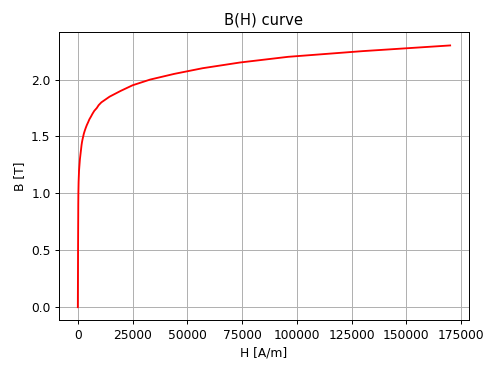

In [13]:
BH = [
    [0.0,0.0],
    [100.0,0.5],
    [150.0,0.7],
    [180.0,0.8],
    [200.0,0.9],
    [250.0,1.0],
    [300.0,1.05],
    [350.0,1.1],
    [450.0,1.15],
    [550.0,1.2],
    [650.0,1.225],
    [750.0,1.25],
    [850.0,1.275],
    [950.0,1.3],
    [1100.0,1.325],
    [1250.0,1.35],
    [1400.0,1.375],
    [1550.0,1.4],
    [1700.0,1.425],
    [1900.0,1.45],
    [2150.0,1.475],
    [2450.0,1.5],
    [2750.0,1.525],
    [3150.0,1.55],
    [3600.0,1.575],
    [4100.0,1.6],
    [4700.0,1.625],
    [5250.0,1.65],
    [6000.0,1.675],
    [6700.0,1.7],
    [7500.0,1.725],
    [8650.0,1.75],
    [9500.0,1.775],
    [10750.0,1.8],
    [14500.0,1.85],
    [19500.0,1.9],
    [25000.0,1.95],
    [33000.0,2.0],
    [44000.0,2.05],
    [57000.0,2.1],
    [74000.0,2.15],
    [96000.0,2.2],
    [130000.0,2.25],
    [170000.0,2.3]
]
M400_50A.mag.BH_curve = BH
fig = M400_50A.mag.plot_BH()

## Create, save and plot the machine
Finally, the Machine object can be created with [**MachineIPMSM**](http://www.pyleecan.org/pyleecan.Classes.MachineIPMSM.html) and saved using the `save` method.

[15:29:44] Saving MachineIPMSM to file 'IPMSM_Toyota_Prius_2004.json'.
Saving MachineIPMSM to file 'IPMSM_Toyota_Prius_2004.json'.


<IPython.core.display.Javascript object>


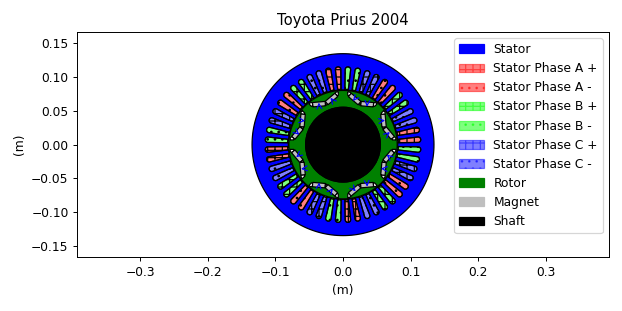

In [14]:
from pyleecan.Classes.MachineIPMSM import MachineIPMSM

%matplotlib notebook
IPMSM_Prius_2004 = MachineIPMSM(
    name="Toyota Prius 2004", 
    stator=stator, 
    rotor=rotor, 
    shaft=shaft, 
    frame=frame  # None
)
IPMSM_Prius_2004.save('IPMSM_Toyota_Prius_2004.json')

im=IPMSM_Prius_2004.plot()

Note that Pyleecan also handles ventilation duct thanks to the classes :  
- [**VentilationCirc**](http://www.pyleecan.org/pyleecan.Classes.VentilationCirc.html)  
- [**VentilationPolar**](http://www.pyleecan.org/pyleecan.Classes.VentilationPolar.html)  
- [**VentilationTrap**](http://www.pyleecan.org/pyleecan.Classes.VentilationTrap.html)  

[1] Z. Yang, M. Krishnamurthy and I. P. Brown, "Electromagnetic and vibrational characteristic of IPM over full torque-speed range", *2013 International Electric Machines & Drives Conference*, Chicago, IL, 2013, pp. 295-302.

[2] P. Bonneel, J. Le Besnerais, E. Devillers, C. Marinel, and R. Pile, “Design Optimization of Innovative Electrical Machines Topologies Based on Pyleecan Opensource Object-Oriented Software,” in 24th International Conference on Electrical Machines (ICEM), 2020.